# Klasifikacija medicinskih slika dubokim konvolucijskim mrežama

Završni projekt iz kolegija *Računalni vid*

Cilj ovog projekta je primjena dubokih konvolucijskih neuronskih mreža
za klasifikaciju bolesti pluća iz rendgenskih (X-ray) snimaka prsnog koša.
Poseban naglasak stavljen je na korištenje transfer learning pristupa
i usporedbu performansi različitih arhitektura.

### Skup podataka: ChestX-ray8

U ovom radu korišten je ChestX-ray8 (NIH) skup podataka koji sadrži više od 100.000 rendgenskih snimaka prsnog koša s anotacijama za više torakalnih bolesti. Zbog multilabel prirode izvornog skupa, problem je u ovom projektu prilagođen višeklasnoj klasifikaciji s osam dijagnostičkih kategorija.

In [4]:
# Uvoz potrebnih biblioteka

# U ovoj ćeliji uvozimo sve osnovne biblioteke potrebne za:
# - obradu i vizualizaciju slika (računalni vid)
# - izgradnju i treniranje dubokih konvolucijskih neuronskih mreža
# - evaluaciju modela korištenjem standardnih metrika

# Projekt se temelji na TensorFlow/Keras okviru, koji omogućuje jednostavnu implementaciju CNN arhitektura i transfer učenja

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50, DenseNet121
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve
)

# Postavka za ljepši prikaz grafova
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (8, 6)

print("Biblioteke uspješno učitane.")

Biblioteke uspješno učitane.


In [6]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ivonaglc","key":"7f3d26d665c2c050732d539e87e0e3c7"}'}

In [7]:
import os

os.makedirs("/root/.kaggle", exist_ok=True)
os.rename("kaggle.json", "/root/.kaggle/kaggle.json")
os.chmod("/root/.kaggle/kaggle.json", 600)

print("Kaggle konfiguracija OK")

Kaggle konfiguracija OK


In [8]:
!kaggle datasets download -d redwankarimsony/chestxray8-dataframe -p /content -q
!kaggle datasets download -d nih-chest-xrays/sample -p /content -q

print("Download gotov")
!ls -lh /content | head -n 20

Dataset URL: https://www.kaggle.com/datasets/redwankarimsony/chestxray8-dataframe
License(s): unknown
Dataset URL: https://www.kaggle.com/datasets/nih-chest-xrays/sample
License(s): CC0-1.0
Download gotov
total 4.3G
-rw-r--r-- 1 root root  52M Jul 12  2020 chestxray8-dataframe.zip
drwx------ 5 root root 4.0K Feb  6 10:44 drive
drwxr-xr-x 1 root root 4.0K Dec  9 14:42 sample_data
-rw-r--r-- 1 root root 4.2G Sep 21  2019 sample.zip


In [9]:
!unzip -q /content/chestxray8-dataframe.zip -d /content/chestxray8_df

!unzip -q /content/sample.zip -d /content/nih_sample

print("Unzip gotov")

!ls /content
!ls /content/chestxray8_df
!ls /content/nih_sample | head -n 10

Unzip gotov
chestxray8-dataframe.zip  drive       sample_data
chestxray8_df		  nih_sample  sample.zip
cxr14_bad_labels.csv  densenet.hdf5  pretrained_model.h5  train_df.csv
sample
sample_labels.csv


In [10]:
import pandas as pd

# Učitavanje CSV datoteka
train_df = pd.read_csv("/content/chestxray8_df/train_df.csv")
bad_labels = pd.read_csv("/content/chestxray8_df/cxr14_bad_labels.csv")

print("train_df shape:", train_df.shape)
print("bad_labels shape:", bad_labels.shape)

# Prvih nekoliko redaka
train_df.head()

train_df shape: (111863, 18)
bad_labels shape: (432, 5)


,Image Index,Patient ID,Cardiomegaly,Emphysema,Effusion,No Finding,Hernia,Infiltration,Mass,Nodule,Atelectasis,Pneumothorax,Pleural_Thickening,Pneumonia,Fibrosis,Edema,Consolidation,FilePath
0,00000001_000.png,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,../input/data/images_001/images/00000001_000.png
1,00000001_001.png,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,../input/data/images_001/images/00000001_001.png
2,00000001_002.png,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,../input/data/images_001/images/00000001_002.png
3,00000002_000.png,2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,../input/data/images_001/images/00000002_000.png
4,00000003_000.png,3,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,../input/data/images_001/images/00000003_000.png


In [14]:
# Priprema multiclass skupa (8 klasa) za ChestX-ray8 sample

# ChestX-ray8 anotacije su često multilabel (više dijagnoza na jednoj slici).
# Budući da je cilj projekta višeklasna klasifikacija, zadržavamo samo one uzorke koji imaju točno jednu pozitivnu oznaku među odabranih 8 bolesti.
# Tako dobivamo korektno definiran multiclass problem (1 slika - 1 klasa).

import os

CLASSES = [
    "Pneumonia", "Emphysema", "Fibrosis", "Edema",
    "Effusion", "Atelectasis", "Pneumothorax", "Cardiomegaly"
]

# Kopija izvornog dataframe-a
df = train_df.copy()

# Mapiranje lokalnih putanja slika (image_map je dobiven pretragom /content/nih_sample)
df["img_path"] = df["Image Index"].map(image_map)

# Broj pozitivnih oznaka među odabranih 8 klasa (multiclass zahtijeva = 1)
df["n_pos_selected"] = df[CLASSES].sum(axis=1)

# Multiclass filtriranje
df_mc = df[
    (df["img_path"].notna()) &
    (df["No Finding"] == 0) &
    (df["n_pos_selected"] == 1)
].copy()

# Ciljna varijabla: label (naziv klase) i label_idx (0..7)
df_mc["label"] = df_mc[CLASSES].idxmax(axis=1)
class_to_idx = {c: i for i, c in enumerate(CLASSES)}
df_mc["label_idx"] = df_mc["label"].map(class_to_idx)

print(f"Ukupno redaka u train_df: {len(train_df)}")
print(f"Mapirano na lokalne slike (sample): {df['img_path'].notna().sum()}")
print(f"Multiclass subset (8 klasa, točno 1 oznaka): {len(df_mc)}")

print("\nRaspodjela klasa (top 8):")
display(df_mc["label"].value_counts())

Ukupno redaka u train_df: 111863
Mapirano na lokalne slike (sample): 5595
Multiclass subset (8 klasa, točno 1 oznaka): 1131

Raspodjela klasa (top 8):


,count
label,
Effusion,367
Atelectasis,302
Pneumothorax,171
Edema,70
Cardiomegaly,67
Emphysema,62
Fibrosis,58
Pneumonia,34


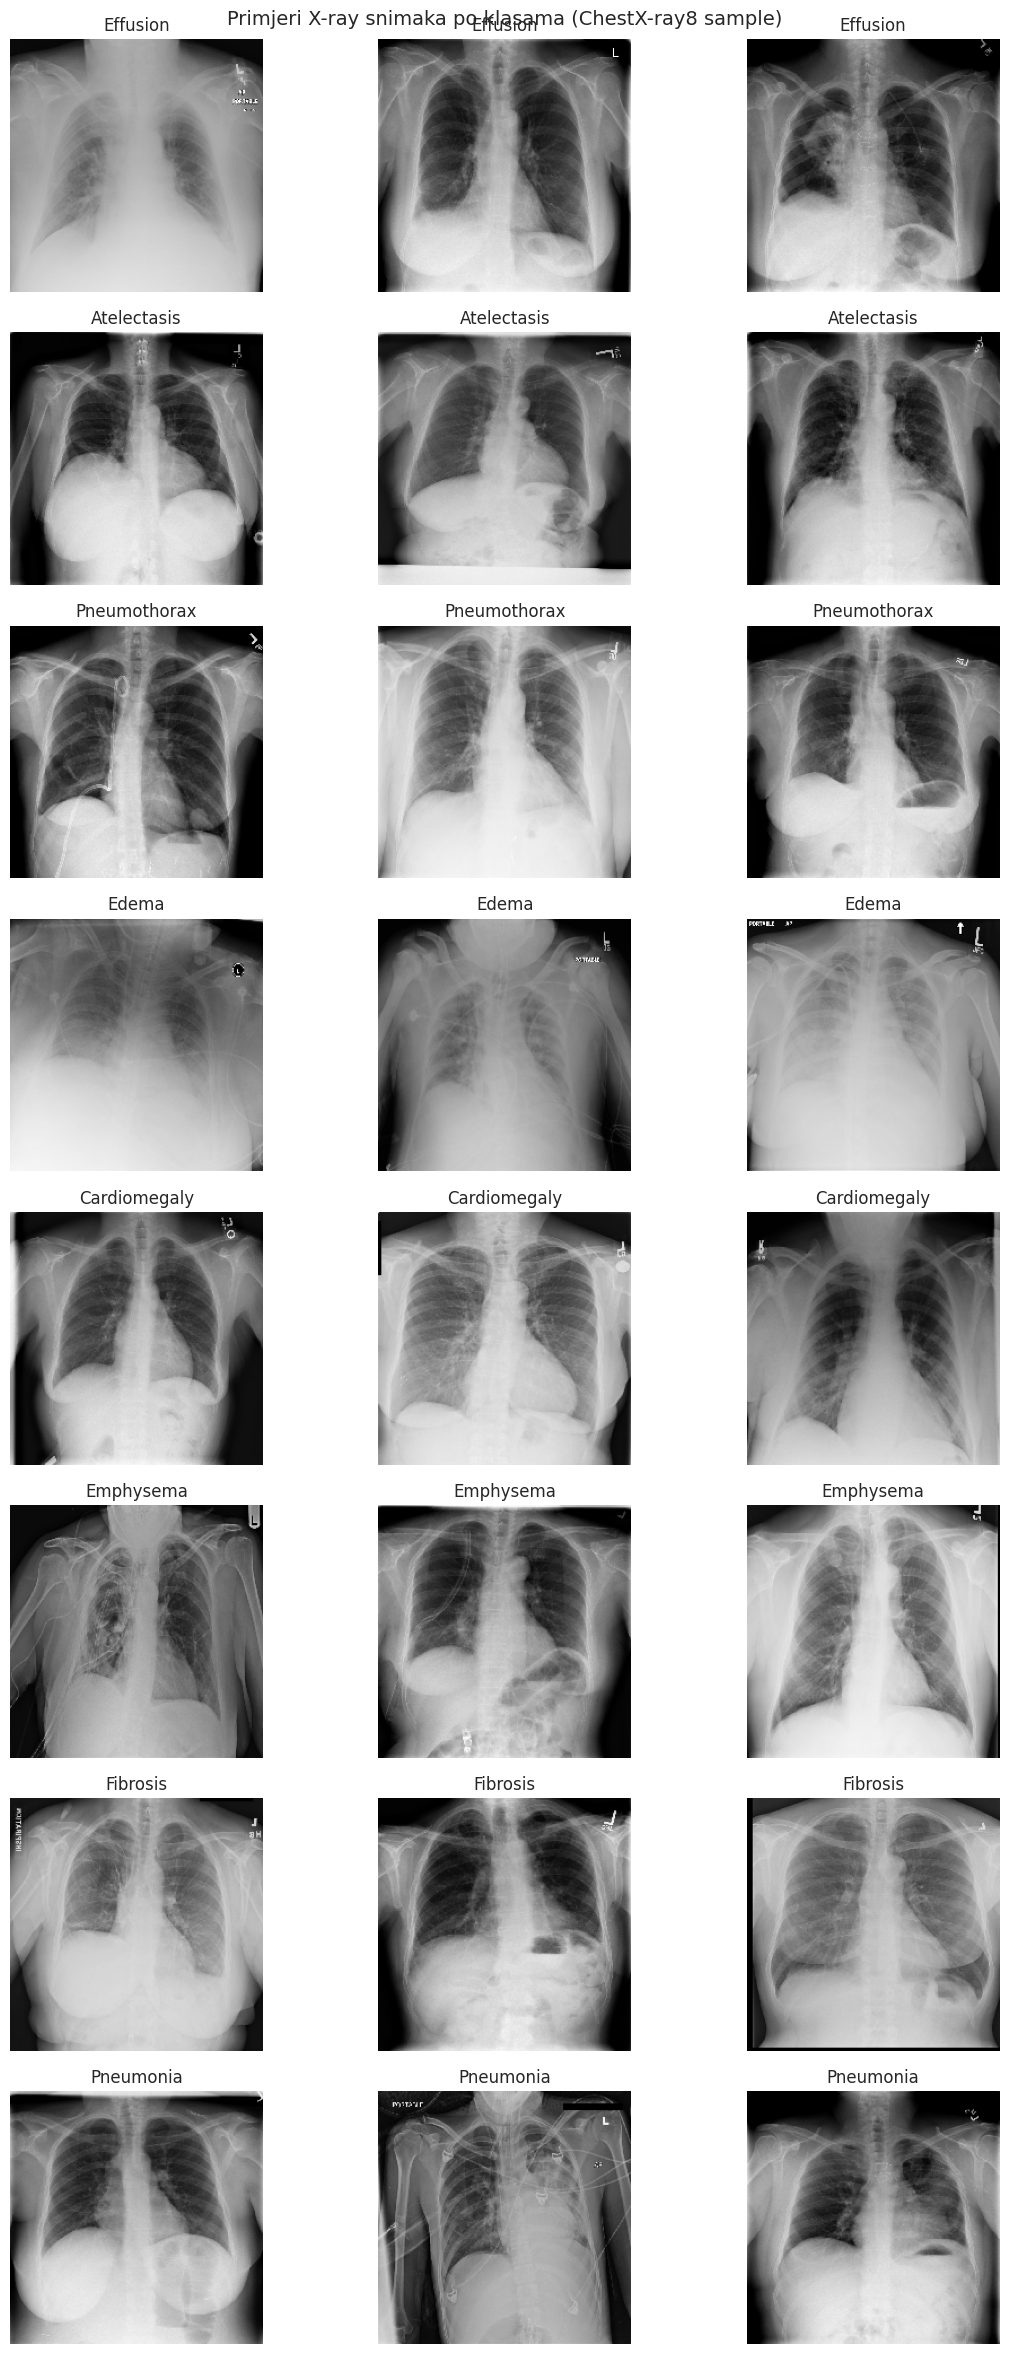

In [15]:
# Vizualna eksplorativna analiza (EDA) X-ray slika

# Cilj ove ćelije je:
# - vizualno pregledati rendgenske snimke po klasama
# - uočiti varijacije u kontrastu, teksturi i anatomskim strukturama
# - steći intuiciju o težini problema klasifikacije bolesti pluća

# Prikaz po nekoliko primjera za svaku klasu

import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Broj primjera po klasi za prikaz
N_SAMPLES_PER_CLASS = 3
IMG_SIZE = (224, 224)

classes_order = df_mc["label"].value_counts().index.tolist()

plt.figure(figsize=(12, 3 * len(classes_order)))

plot_idx = 1
for cls in classes_order:
    cls_samples = df_mc[df_mc["label"] == cls].sample(
        min(N_SAMPLES_PER_CLASS, len(df_mc[df_mc["label"] == cls])),
        random_state=42
    )

    for _, row in cls_samples.iterrows():
        img = load_img(row["img_path"], target_size=IMG_SIZE, color_mode="rgb")
        img_arr = img_to_array(img).astype("uint8")

        plt.subplot(len(classes_order), N_SAMPLES_PER_CLASS, plot_idx)
        plt.imshow(img_arr)
        plt.title(cls)
        plt.axis("off")
        plot_idx += 1

plt.suptitle("Primjeri X-ray snimaka po klasama (ChestX-ray8 sample)", fontsize=14)
plt.tight_layout()
plt.show()

In [16]:
# Podjela podataka + normalizacija i augmentacija

# U ovoj ćeliji pripremamo podatke za treniranje CNN modela:
# 1. dijelimo podatke na train / validation / test skupove
# 2. provodimo normalizaciju intenziteta piksela
# 3. primjenjujemo augmentaciju podataka na trening skupu kako bismo smanjili overfitting i povećali robusnost modela

# Augmentacija je posebno važna u medicinskom računalnom vidu zbog ograničenog broja označenih podataka i nebalansa klasa

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Veličina ulazne slike (standard za ResNet/DenseNet)
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# 1. Podjela na train+val i test (80% / 20%)
train_val_df, test_df = train_test_split(
    df_mc,
    test_size=0.20,
    stratify=df_mc["label_idx"],
    random_state=42
)

# 2. Daljnja podjela train+val na train i validation (80% / 20%)
train_df, val_df = train_test_split(
    train_val_df,
    test_size=0.20,
    stratify=train_val_df["label_idx"],
    random_state=42
)

print("Veličine skupova:")
print(f"Train: {len(train_df)}")
print(f"Validation: {len(val_df)}")
print(f"Test: {len(test_df)}")

# 3. ImageDataGenerator za trening skup
#    - rescale: normalizacija piksela u raspon [0, 1]
#    - augmentacije: realistične transformacije X-ray slika
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.1,
    horizontal_flip=True
)

# 4. Generator za validation i test skup (bez augmentacije – samo normalizacija)
eval_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0
)

# 5. Kreiranje generatora
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col="img_path",
    y_col="label",
    target_size=IMG_SIZE,
    class_mode="categorical", # višeklasna klasifikacija
    batch_size=BATCH_SIZE,
    shuffle=True
)

val_generator = eval_datagen.flow_from_dataframe(
    val_df,
    x_col="img_path",
    y_col="label",
    target_size=IMG_SIZE,
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_generator = eval_datagen.flow_from_dataframe(
    test_df,
    x_col="img_path",
    y_col="label",
    target_size=IMG_SIZE,
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    shuffle=False
)

# Provjera mapiranja klasa
print("\n Mapiranje klasa (label → indeks):")
print(train_generator.class_indices)

Veličine skupova:
Train: 723
Validation: 181
Test: 227
Found 723 validated image filenames belonging to 8 classes.
Found 181 validated image filenames belonging to 8 classes.
Found 227 validated image filenames belonging to 8 classes.

 Mapiranje klasa (label → indeks):
{'Atelectasis': 0, 'Cardiomegaly': 1, 'Edema': 2, 'Effusion': 3, 'Emphysema': 4, 'Fibrosis': 5, 'Pneumonia': 6, 'Pneumothorax': 7}


In [17]:
# Definicija vlastite (baseline) CNN arhitekture

# Cilj baseline modela je imati jednostavniju CNN mrežu koju smo sami osmislili, kako bismo mogli usporediti njezine performanse s transfer learning modelima (ResNet50 i DenseNet121)
# Budući da radimo višeklasnu klasifikaciju s 8 klasa:
# - zadnji sloj mora imati 8 neurona
# - koristimo Softmax aktivaciju
# - koristimo gubitak categorical_crossentropy

NUM_CLASSES = len(train_generator.class_indices)

baseline_cnn = models.Sequential([
    layers.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),

    layers.Conv2D(32, (3, 3), padding="same", activation="relu"),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    layers.Conv2D(64, (3, 3), padding="same", activation="relu"),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    layers.Conv2D(128, (3, 3), padding="same", activation="relu"),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.30),

    layers.Flatten(),
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.40),

    # ZADNJI SLOJ: prilagodba za višeklasnu klasifikaciju (8 klasa)
    layers.Dense(NUM_CLASSES, activation="softmax")
])

baseline_cnn.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

baseline_cnn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    25,690,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │         2,056 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,785,672 (98.36 MB)

 Trainable params: 25,785,672 (98.36 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
# Treniranje baseline CNN modela

# Koristimo:
# - EarlyStopping: prekida treniranje kad se validacijski gubitak ne poboljšava, čime smanjujemo overfitting i skraćujemo vrijeme izvođenja
# - ModelCheckpoint: sprema najbolji model (najniži val_loss) za kasniju evaluaciju

# Ovaj baseline model služi kao referenca za usporedbu s transfer learning modelima

EPOCHS = 15

baseline_callbacks = [
    EarlyStopping(
        monitor="val_loss",
        patience=3,
        restore_best_weights=True
    ),
    ModelCheckpoint(
        filepath="baseline_cnn_best.h5",
        monitor="val_loss",
        save_best_only=True
    )
]

history_baseline = baseline_cnn.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=baseline_callbacks,
    verbose=1
)

print("Treniranje baseline CNN završeno. Najbolji model je spremljen kao 'baseline_cnn_best.h5'.")

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2634 - loss: 2.0374

23/23 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - accuracy: 0.2644 - loss: 2.0334 - val_accuracy: 0.3260 - val_loss: 1.9450
Epoch 2/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.3148 - loss: 1.7971 - val_accuracy: 0.3260 - val_loss: 1.9855
Epoch 3/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.3102 - loss: 1.8030 - val_accuracy: 0.2707 - val_loss: 1.9884
Epoch 4/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.3206 - loss: 1.8067 - val_accuracy: 0.3094 - val_loss: 1.9556
Treniranje baseline CNN završeno. Najbolji model je spremljen kao 'baseline_cnn_best.h5'.


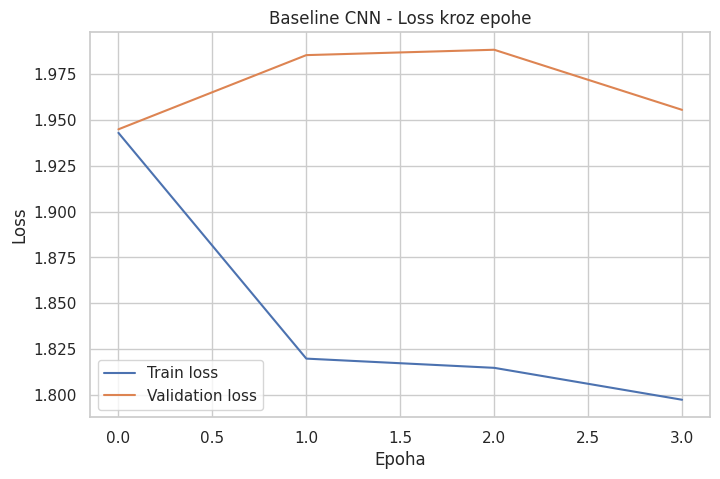

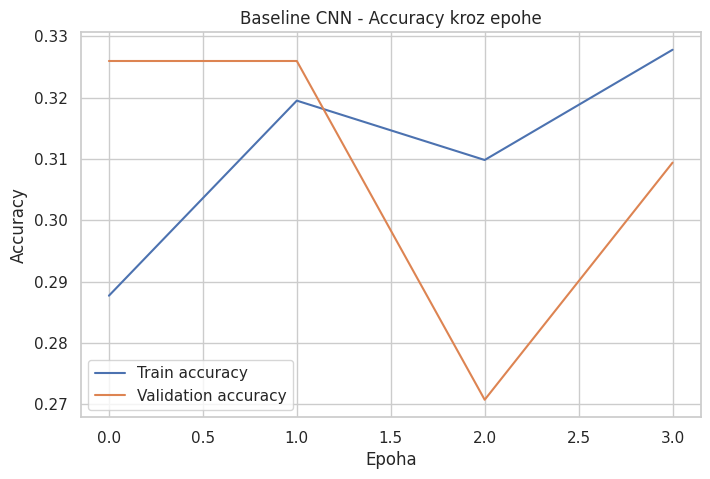

Model spremljen kao 'baseline_cnn_best.keras'.


In [19]:
# Vizualizacija procesa treniranja (baseline CNN)

# Prikaz:
# - loss i val_loss: pomaže u uočavanju overfittinga/underfittinga
# - accuracy i val_accuracy: pregled napretka modela po epohama

import matplotlib.pyplot as plt

# Loss graf
plt.figure(figsize=(8, 5))
plt.plot(history_baseline.history["loss"], label="Train loss")
plt.plot(history_baseline.history["val_loss"], label="Validation loss")
plt.title("Baseline CNN - Loss kroz epohe")
plt.xlabel("Epoha")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Accuracy graf
plt.figure(figsize=(8, 5))
plt.plot(history_baseline.history["accuracy"], label="Train accuracy")
plt.plot(history_baseline.history["val_accuracy"], label="Validation accuracy")
plt.title("Baseline CNN - Accuracy kroz epohe")
plt.xlabel("Epoha")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Spremanje modela u modernom Keras formatu
baseline_cnn.save("baseline_cnn_best.keras")
print("Model spremljen kao 'baseline_cnn_best.keras'.")

In [20]:
# ResNet50 (Transfer Learning) - definicija modela

# Transfer learning:
# - koristimo unaprijed istrenirani model (ImageNet) kao extractor značajki
# - zamrzavamo (freeze) bazne slojeve kako bi se trenirali samo novi završni slojevi

# Prilagodba za višeklasnu klasifikaciju:
# - dodajemo klasifikacijsku "glavu" s NUM_CLASSES neurona i softmax aktivacijom
# - koristimo categorical_crossentropy kao funkciju gubitka

from tensorflow.keras.applications.resnet50 import preprocess_input

NUM_CLASSES = len(train_generator.class_indices)

# 1. Generatori specifični za ResNet50 (augmentacija + preprocess_input)
train_datagen_resnet = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.1,
    horizontal_flip=True
)

eval_datagen_resnet = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

train_gen_resnet = train_datagen_resnet.flow_from_dataframe(
    train_df,
    x_col="img_path",
    y_col="label",
    target_size=IMG_SIZE,
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    shuffle=True
)

val_gen_resnet = eval_datagen_resnet.flow_from_dataframe(
    val_df,
    x_col="img_path",
    y_col="label",
    target_size=IMG_SIZE,
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    shuffle=False
)

# 2. Učitavanje ResNet50 baze bez završnog klasifikatora
base_resnet = ResNet50(
    weights="imagenet",
    include_top=False,
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)
)

# Zamrzavanje baze (prva faza transfer learninga)
base_resnet.trainable = False

# 3. Dodavanje nove "glave" za 8 klasa (multiclass)
inputs = layers.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
x = base_resnet(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)

# Završni sloj prilagođen višeklasnoj klasifikaciji (8 klasa)
outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

resnet_model = models.Model(inputs, outputs)

resnet_model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

resnet_model.summary()
print("ResNet50 model je spreman (baza zamrznuta, završni sloj prilagođen za 8 klasa).")

Found 723 validated image filenames belonging to 8 classes.
Found 181 validated image filenames belonging to 8 classes.
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │        16,392 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,604,104 (90.04 MB)

 Trainable params: 16,392 (64.03 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

ResNet50 model je spreman (baza zamrznuta, završni sloj prilagođen za 8 klasa).


In [21]:
# Treniranje ResNet50 modela (Transfer learning - faza 1)

# U fazi 1 treniramo samo završne slojeve (klasifikacijsku glavu), dok je baza ResNet50 zamrznuta. Time:
# - brzo prilagođavamo model novom zadatku
# - smanjujemo rizik overfittinga na malom uzorku
# - dobivamo stabilnu početnu točku prije finog podešavanja (fine-tuning)

# Koristimo EarlyStopping i spremamo najbolji model u .keras formatu

EPOCHS_RESNET_1 = 10

resnet_callbacks = [
    EarlyStopping(
        monitor="val_loss",
        patience=3,
        restore_best_weights=True
    ),
    ModelCheckpoint(
        filepath="resnet50_phase1_best.keras",
        monitor="val_loss",
        save_best_only=True
    )
]

history_resnet_1 = resnet_model.fit(
    train_gen_resnet,
    validation_data=val_gen_resnet,
    epochs=EPOCHS_RESNET_1,
    callbacks=resnet_callbacks,
    verbose=1
)

print("ResNet50 faza 1 završena. Najbolji model spremljen kao 'resnet50_phase1_best.keras'.")

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - accuracy: 0.1111 - loss: 3.1027 - val_accuracy: 0.2707 - val_loss: 2.0230
Epoch 2/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.2627 - loss: 2.1888 - val_accuracy: 0.2707 - val_loss: 1.8952
Epoch 3/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.2391 - loss: 2.1902 - val_accuracy: 0.2707 - val_loss: 1.8642
Epoch 4/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.2558 - loss: 2.2129 - val_accuracy: 0.2762 - val_loss: 1.8358
Epoch 5/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.2665 - loss: 2.1496 - val_accuracy: 0.2873 - val_loss: 1.8432
Epoch 6/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.2670 - loss: 2.0877 - val_accuracy: 0.2928 - val_loss: 1.8139
Epoch 7/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.2936 - loss: 2.0338 - val_accuracy: 0.2818 - val_loss: 1.8033
Epoch 8/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.3026 - loss: 2.0066 - val_accuracy: 0.3039 - val_loss:

In [22]:
# ResNet50 fine-tuning (Transfer learning - faza 2)

# U fazi 2 radimo "fine-tuning":
# - odmrzavamo samo dio ResNet50 baze (zadnje slojeve)
# - treniramo s manjim learning rate-om kako bismo pažljivo prilagodili prethodno naučene značajke (ImageNet) medicinskom domenskom zadatku

# Ovim korakom često se dobije dodatno poboljšanje performansi

from tensorflow.keras.models import load_model

# 1. Učitavanje najboljeg modela iz faze 1
resnet_model = load_model("resnet50_phase1_best.keras")

# 2. Pronalazak baze (ResNet50) unutar modela i djelomično odmrzavanje
base_model = resnet_model.get_layer("resnet50")

# Odmrzavamo bazu
base_model.trainable = True

# Zamrzavamo većinu slojeva i odmrzavamo samo zadnjih N slojeva
# (N je kompromis: dovoljno za adaptaciju, a da se ne overfitta na mali uzorak)
N_UNFREEZE = 40

for layer in base_model.layers[:-N_UNFREEZE]:
    layer.trainable = False

print("Broj trainable slojeva u bazi:",
      sum([1 for l in base_model.layers if l.trainable]),
      "od ukupno", len(base_model.layers))

# 3. Ponovno kompajliranje s manjim learning rate-om
resnet_model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# 4. Callbackovi za fine-tuning
EPOCHS_RESNET_2 = 10

resnet_ft_callbacks = [
    EarlyStopping(
        monitor="val_loss",
        patience=3,
        restore_best_weights=True
    ),
    ModelCheckpoint(
        filepath="resnet50_finetuned_best.keras",
        monitor="val_loss",
        save_best_only=True
    )
]

history_resnet_2 = resnet_model.fit(
    train_gen_resnet,
    validation_data=val_gen_resnet,
    epochs=EPOCHS_RESNET_2,
    callbacks=resnet_ft_callbacks,
    verbose=1
)

print("ResNet50 fine-tuning završen. Najbolji model spremljen kao 'resnet50_finetuned_best.keras'.")

Broj trainable slojeva u bazi: 40 od ukupno 175
Epoch 1/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 70s 2s/step - accuracy: 0.3181 - loss: 2.0457 - val_accuracy: 0.3204 - val_loss: 1.8003
Epoch 2/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.3278 - loss: 1.9027 - val_accuracy: 0.3094 - val_loss: 1.8450
Epoch 3/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.3474 - loss: 1.7951 - val_accuracy: 0.3094 - val_loss: 1.9035
Epoch 4/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.3996 - loss: 1.6361 - val_accuracy: 0.3370 - val_loss: 1.8854
ResNet50 fine-tuning završen. Najbolji model spremljen kao 'resnet50_finetuned_best.keras'.


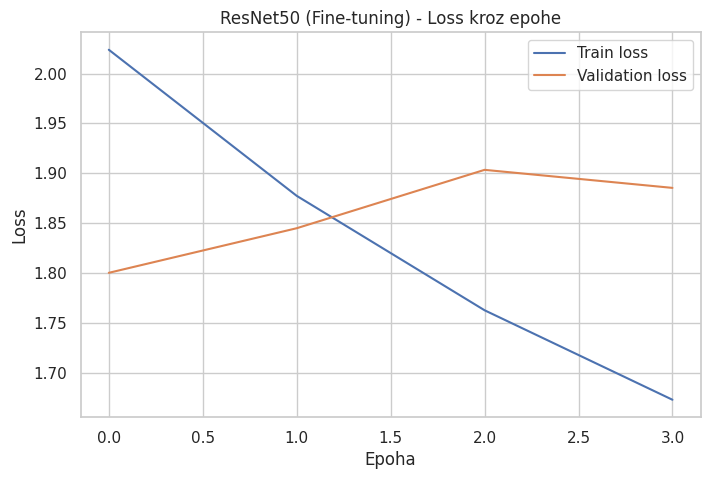

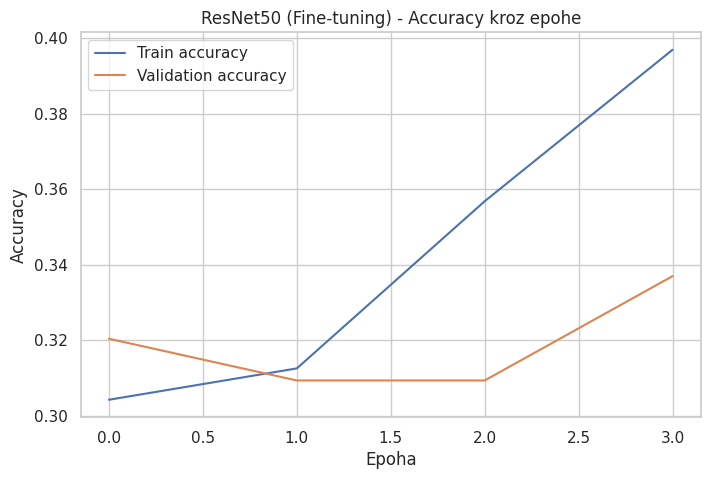

In [33]:
# Vizualizacija procesa treniranja (ResNet50 – fine-tuning faza)
# Prikaz:
# - loss i val_loss: stabilnost učenja nakon odmrzavanja dijela baze
# - accuracy i val_accuracy: poboljšanje performansi tijekom fine-tuninga

import matplotlib.pyplot as plt

# Loss graf
plt.figure(figsize=(8, 5))
plt.plot(history_resnet_2.history["loss"], label="Train loss")
plt.plot(history_resnet_2.history["val_loss"], label="Validation loss")
plt.title("ResNet50 (Fine-tuning) - Loss kroz epohe")
plt.xlabel("Epoha")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Accuracy graf
plt.figure(figsize=(8, 5))
plt.plot(history_resnet_2.history["accuracy"], label="Train accuracy")
plt.plot(history_resnet_2.history["val_accuracy"], label="Validation accuracy")
plt.title("ResNet50 (Fine-tuning) - Accuracy kroz epohe")
plt.xlabel("Epoha")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [23]:
# DenseNet121 (Transfer Learning) - definicija modela

# DenseNet121 je često vrlo učinkovit na medicinskim slikama jer koristi "dense connections" (svaki sloj dobiva informacije iz prethodnih)

# Kao i kod ResNet-a, radimo transfer learning:
# - učitamo DenseNet121 bez originalnog klasifikatora (include_top=False),
# - zamrznemo bazu,
# - dodamo novu klasifikacijsku glavu za 8 klasa (softmax).

# Napomena o normalizaciji:
# - koristimo preprocess_input specifičan za DenseNet

from tensorflow.keras.applications.densenet import preprocess_input as densenet_preprocess

# 1. Generatori specifični za DenseNet121 (augmentacija + preprocess_input)
train_datagen_dense = ImageDataGenerator(
    preprocessing_function=densenet_preprocess,
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.1,
    horizontal_flip=True
)

eval_datagen_dense = ImageDataGenerator(
    preprocessing_function=densenet_preprocess
)

train_gen_dense = train_datagen_dense.flow_from_dataframe(
    train_df,
    x_col="img_path",
    y_col="label",
    target_size=IMG_SIZE,
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    shuffle=True
)

val_gen_dense = eval_datagen_dense.flow_from_dataframe(
    val_df,
    x_col="img_path",
    y_col="label",
    target_size=IMG_SIZE,
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    shuffle=False
)

# 2. Učitavanje DenseNet121 baze bez završnog klasifikatora
base_dense = DenseNet121(
    weights="imagenet",
    include_top=False,
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)
)

# Zamrzavanje baze (faza 1 transfer learninga)
base_dense.trainable = False

# 3. Nova klasifikacijska glava za 8 klasa (multiclass)
inputs = layers.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
x = base_dense(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)

# Završni sloj prilagođen višeklasnoj klasifikaciji (8 klasa)
outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

densenet_model = models.Model(inputs, outputs)

densenet_model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

densenet_model.summary()
print("DenseNet121 model je spreman (baza zamrznuta, završni sloj prilagođen za 8 klasa).")

Found 723 validated image filenames belonging to 8 classes.
Found 181 validated image filenames belonging to 8 classes.
29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet121 (Functional)        │ (None, 7, 7, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8)              │         8,200 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,045,704 (26.88 MB)

 Trainable params: 8,200 (32.03 KB)

 Non-trainable params: 7,037,504 (26.85 MB)

DenseNet121 model je spreman (baza zamrznuta, završni sloj prilagođen za 8 klasa).


In [24]:
# Treniranje DenseNet121 (Transfer learning - faza 1)

# U fazi 1 treniramo samo klasifikacijsku glavu, dok je DenseNet121 baza zamrznuta
# Time brzo prilagođavamo model novom problemu uz manji rizik overfittinga

# - EarlyStopping: prekida ako se val_loss ne poboljšava
# - ModelCheckpoint: sprema najbolji model u .keras formatu

EPOCHS_DENSE_1 = 10

dense_callbacks = [
    EarlyStopping(
        monitor="val_loss",
        patience=3,
        restore_best_weights=True
    ),
    ModelCheckpoint(
        filepath="densenet121_phase1_best.keras",
        monitor="val_loss",
        save_best_only=True
    )
]

history_dense_1 = densenet_model.fit(
    train_gen_dense,
    validation_data=val_gen_dense,
    epochs=EPOCHS_DENSE_1,
    callbacks=dense_callbacks,
    verbose=1
)

print("DenseNet121 faza 1 završena. Najbolji model spremljen kao 'densenet121_phase1_best.keras'.")

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 100s 3s/step - accuracy: 0.0727 - loss: 3.1238 - val_accuracy: 0.1381 - val_loss: 2.2376
Epoch 2/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.2170 - loss: 2.3866 - val_accuracy: 0.3149 - val_loss: 1.9896
Epoch 3/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.2530 - loss: 2.2341 - val_accuracy: 0.3204 - val_loss: 1.9300
Epoch 4/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.2461 - loss: 2.2042 - val_accuracy: 0.3370 - val_loss: 1.9128
Epoch 5/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.2526 - loss: 2.1204 - val_accuracy: 0.3315 - val_loss: 1.9041
Epoch 6/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.2642 - loss: 2.1838 - val_accuracy: 0.3315 - val_loss: 1.8932
Epoch 7/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.2872 - loss: 2.1747 - val_accuracy: 0.3204 - val_loss: 1.8876
Epoch 8/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.2556 - loss: 2.1379 - val_accuracy: 0.3315 - val_loss

In [25]:
# DenseNet121 fine-tuning (Transfer learning - faza 2)

# Nakon treniranja samo "glave" (faza 1), radimo fine-tuning:
# - odmrzavamo dio DenseNet121 baze (zadnje slojeve)
# - treniramo s manjim learning rate-om kako bismo pažljivo prilagodili reprezentacije novoj domeni (medicinske X-ray slike)

# Fine-tuning često poboljšava performanse, ali na malom uzorku može dovesti do overfittinga, zato koristimo EarlyStopping

from tensorflow.keras.models import load_model

# 1. Učitavanje najboljeg modela iz faze 1
densenet_model = load_model("densenet121_phase1_best.keras")

# 2. Pronalazak baze unutar modela i djelomično odmrzavanje
base_model = densenet_model.get_layer("densenet121")
base_model.trainable = True

# Odmrzavamo samo zadnjih N slojeva baze
N_UNFREEZE = 40
for layer in base_model.layers[:-N_UNFREEZE]:
    layer.trainable = False

print("Broj trainable slojeva u bazi:",
      sum([1 for l in base_model.layers if l.trainable]),
      "od ukupno", len(base_model.layers))

# 3. Ponovno kompajliranje s manjim learning rate-om
densenet_model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# 4. Callbackovi
EPOCHS_DENSE_2 = 10

dense_ft_callbacks = [
    EarlyStopping(
        monitor="val_loss",
        patience=3,
        restore_best_weights=True
    ),
    ModelCheckpoint(
        filepath="densenet121_finetuned_best.keras",
        monitor="val_loss",
        save_best_only=True
    )
]

history_dense_2 = densenet_model.fit(
    train_gen_dense,
    validation_data=val_gen_dense,
    epochs=EPOCHS_DENSE_2,
    callbacks=dense_ft_callbacks,
    verbose=1
)

print("DenseNet121 fine-tuning završen. Najbolji model spremljen kao 'densenet121_finetuned_best.keras'.")

Broj trainable slojeva u bazi: 40 od ukupno 427
Epoch 1/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 110s 3s/step - accuracy: 0.2833 - loss: 2.1521 - val_accuracy: 0.3536 - val_loss: 1.8674
Epoch 2/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.2814 - loss: 2.0486 - val_accuracy: 0.3425 - val_loss: 1.8670
Epoch 3/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.3044 - loss: 2.0497 - val_accuracy: 0.3481 - val_loss: 1.8670
Epoch 4/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.2888 - loss: 1.9886 - val_accuracy: 0.3425 - val_loss: 1.8681
Epoch 5/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.2824 - loss: 2.0351 - val_accuracy: 0.3315 - val_loss: 1.8686
DenseNet121 fine-tuning završen. Najbolji model spremljen kao 'densenet121_finetuned_best.keras'.


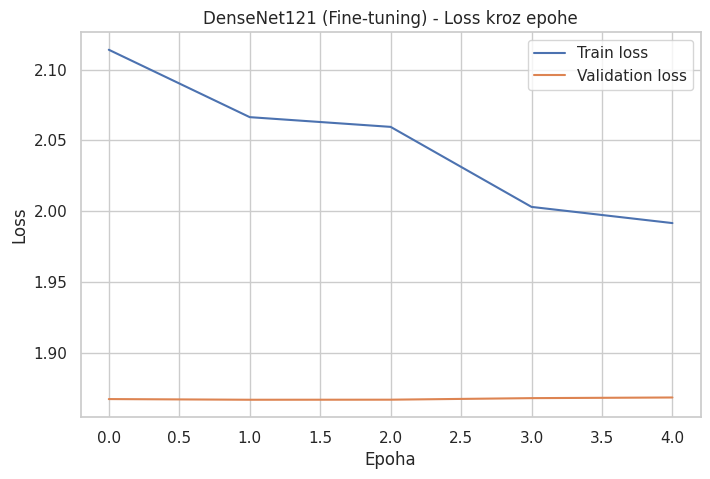

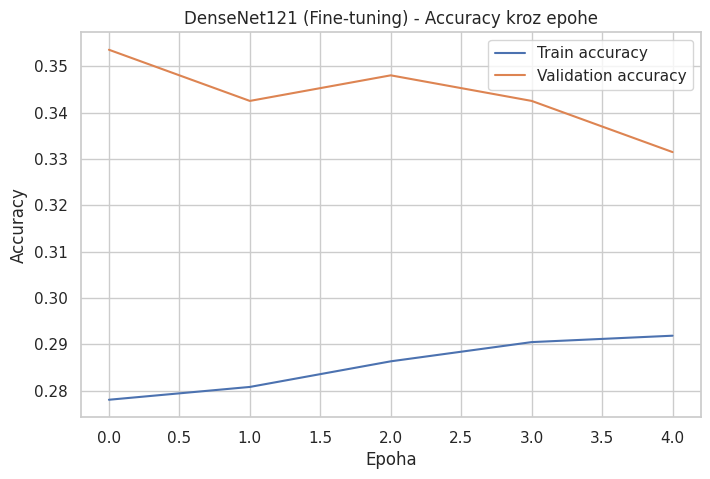

In [34]:
# Vizualizacija procesa treniranja (DenseNet121 – fine-tuning faza)
# Prikaz:
# - loss i val_loss: ponašanje funkcije gubitka nakon fine-tuninga
# - accuracy i val_accuracy: konvergencija modela i generalizacija

# Loss graf
plt.figure(figsize=(8, 5))
plt.plot(history_dense_2.history["loss"], label="Train loss")
plt.plot(history_dense_2.history["val_loss"], label="Validation loss")
plt.title("DenseNet121 (Fine-tuning) - Loss kroz epohe")
plt.xlabel("Epoha")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Accuracy graf
plt.figure(figsize=(8, 5))
plt.plot(history_dense_2.history["accuracy"], label="Train accuracy")
plt.plot(history_dense_2.history["val_accuracy"], label="Validation accuracy")
plt.title("DenseNet121 (Fine-tuning) - Accuracy kroz epohe")
plt.xlabel("Epoha")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 12 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))



 Evaluacija modela: Baseline CNN

Classification report:
              precision    recall  f1-score   support

 Atelectasis       0.00      0.00      0.00        61
Cardiomegaly       0.00      0.00      0.00        13
       Edema       0.00      0.00      0.00        14
    Effusion       0.33      1.00      0.49        74
   Emphysema       0.00      0.00      0.00        12
    Fibrosis       0.00      0.00      0.00        12
   Pneumonia       0.00      0.00      0.00         7
Pneumothorax       0.00      0.00      0.00        34

    accuracy                           0.33       227
   macro avg       0.04      0.12      0.06       227
weighted avg       0.11      0.33      0.16       227



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


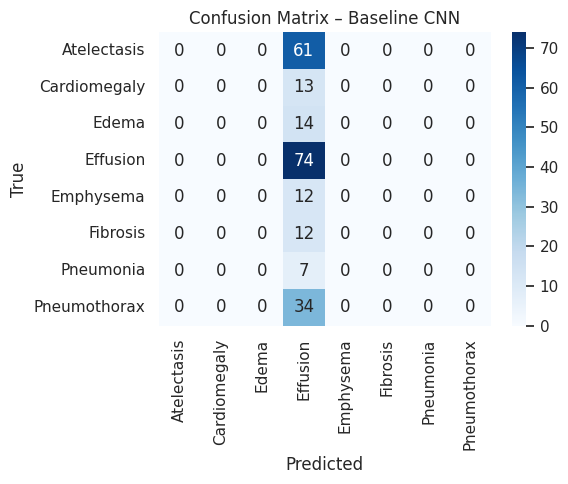


 Evaluacija modela: ResNet50

Classification report:
              precision    recall  f1-score   support

 Atelectasis       0.00      0.00      0.00        61
Cardiomegaly       0.00      0.00      0.00        13
       Edema       0.06      1.00      0.12        14
    Effusion       0.00      0.00      0.00        74
   Emphysema       0.00      0.00      0.00        12
    Fibrosis       0.00      0.00      0.00        12
   Pneumonia       0.00      0.00      0.00         7
Pneumothorax       0.00      0.00      0.00        34

    accuracy                           0.06       227
   macro avg       0.01      0.12      0.01       227
weighted avg       0.00      0.06      0.01       227



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


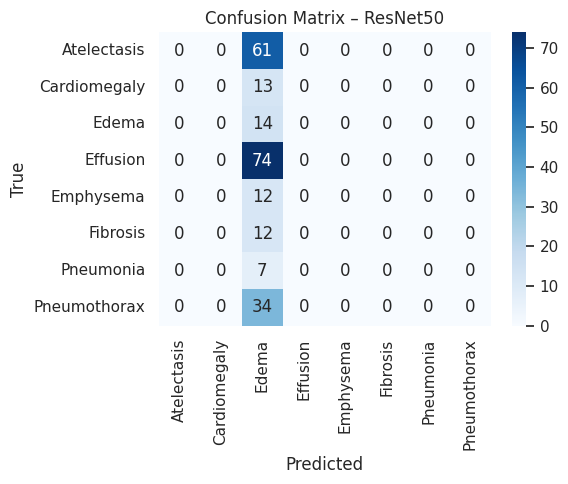


 Evaluacija modela: DenseNet121



Classification report:
              precision    recall  f1-score   support

 Atelectasis       0.31      0.66      0.42        61
Cardiomegaly       0.00      0.00      0.00        13
       Edema       0.00      0.00      0.00        14
    Effusion       0.36      0.38      0.37        74
   Emphysema       0.00      0.00      0.00        12
    Fibrosis       0.00      0.00      0.00        12
   Pneumonia       0.00      0.00      0.00         7
Pneumothorax       0.08      0.03      0.04        34

    accuracy                           0.30       227
   macro avg       0.09      0.13      0.10       227
weighted avg       0.21      0.30      0.24       227



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


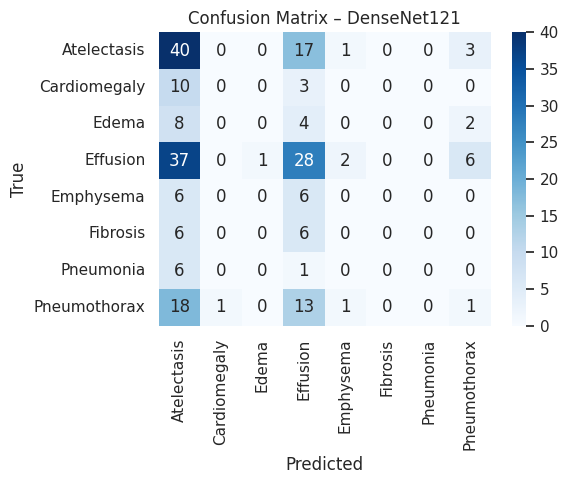

In [26]:
# Evaluacija modela na test skupu

# U ovoj ćeliji evaluiramo:
# 1. baseline CNN
# 2. ResNet50 (fine-tuned)
# 3. DenseNet121 (fine-tuned)

# Računamo:
# - accuracy
# - precision, recall, F1-score (po klasama i ukupno)
# - matricu zabune

import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Učitavanje najboljih modela
baseline_model = load_model("baseline_cnn_best.keras")
resnet_model = load_model("resnet50_finetuned_best.keras")
densenet_model = load_model("densenet121_finetuned_best.keras")

models_dict = {
    "Baseline CNN": baseline_model,
    "ResNet50": resnet_model,
    "DenseNet121": densenet_model
}

# Pravi labeli (one-hot - class index)
y_true = test_generator.classes
class_names = list(test_generator.class_indices.keys())

def evaluate_model(model, generator, model_name):
    print(f"\n Evaluacija modela: {model_name}")

    # Predikcije
    y_pred_prob = model.predict(generator, verbose=0)
    y_pred = np.argmax(y_pred_prob, axis=1)

    # Classification report
    print("\nClassification report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names,
                yticklabels=class_names)
    plt.title(f"Confusion Matrix – {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

# Evaluacija svih modela
for name, model in models_dict.items():
    evaluate_model(model, test_generator, name)

In [27]:
# ROC-AUC analiza (multiclass, one-vs-rest)

# ROC-AUC mjeri sposobnost modela da razdvoji klase neovisno o odabranom pragu odluke

# Za višeklasni problem koristimo one-vs-rest pristup

from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score

# Pravi labeli (binarizirani)
y_true_bin = label_binarize(y_true, classes=range(NUM_CLASSES))

def compute_multiclass_auc(model, generator, model_name):
    y_prob = model.predict(generator, verbose=0)
    auc = roc_auc_score(y_true_bin, y_prob, average="macro", multi_class="ovr")
    print(f"ROC-AUC ({model_name}): {auc:.3f}")

compute_multiclass_auc(baseline_model, test_generator, "Baseline CNN")
compute_multiclass_auc(resnet_model, test_generator, "ResNet50")
compute_multiclass_auc(densenet_model, test_generator, "DenseNet121")

ROC-AUC (Baseline CNN): 0.511
ROC-AUC (ResNet50): 0.472
ROC-AUC (DenseNet121): 0.516


In [28]:
# Usporedna tablica performansi modela

# Tablica sažima ključne metrike korištene u evaluaciji:
# - Accuracy
# - Weighted F1-score (robustan na nebalansirane klase)
# - ROC-AUC (one-vs-rest, multiclass)

# Ova tablica služi kao osnova za zaključak i raspravu rezultata

import pandas as pd
from sklearn.metrics import accuracy_score, f1_score

def collect_metrics(model, generator, model_name):
    y_true = generator.classes
    y_prob = model.predict(generator, verbose=0)
    y_pred = y_prob.argmax(axis=1)

    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average="weighted")
    auc = roc_auc_score(y_true_bin, y_prob, average="macro", multi_class="ovr")

    return {
        "Model": model_name,
        "Accuracy": round(acc, 3),
        "Weighted F1-score": round(f1, 3),
        "ROC-AUC": round(auc, 3)
    }

results = [
    collect_metrics(baseline_model, test_generator, "Baseline CNN"),
    collect_metrics(resnet_model, test_generator, "ResNet50"),
    collect_metrics(densenet_model, test_generator, "DenseNet121")
]

results_df = pd.DataFrame(results)

display(results_df)

,Model,Accuracy,Weighted F1-score,ROC-AUC
0,Baseline CNN,0.326,0.160,0.511
1,ResNet50,0.062,0.007,0.472
2,DenseNet121,0.304,0.239,0.516
